## Week 3 : Logistic Regression 
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Recap on Logistic Regression
2. Data for Classification Task
3. Classification task evaluation metrics
4. Dealing with data imbalance (self practice)
```

<hr>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. The Sigmoid fucnction

$$\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}$$
* **Domain**: \($-∞, +∞$\)
* **Range**: $(0, +1)$
* **Derivative**: $σ'(x) = \sigma(x)(1 - \sigma(x))$

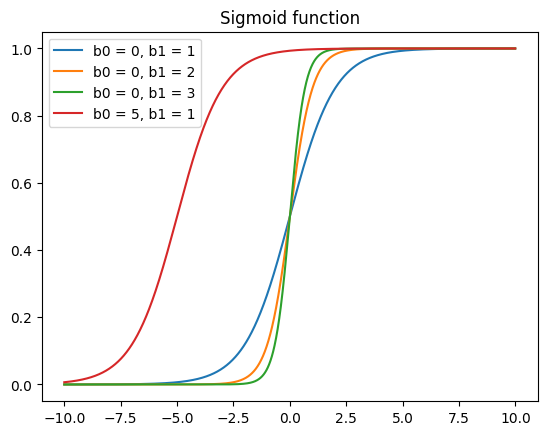

In [3]:
x = np.arange(-10, 10, 0.01)

def plot(b0, b1):
    p = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)

plot(0,1)
plot(0,2)
plot(0,3)
plot(5,1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

## 2. Data for Classification Task

* How is data for regression different from classification task different? 

Covid-19 Dataset collected is from March 2020 - November 2021. The target/goal is to predict the disease based on the patient state. 

<strong>Target Feature: Corona Result.</strong>

<strong>Task:</strong> apply the tools of machine learning to predict which patients got infected by Covid-19.

## 3. Load Data

In [4]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn: 
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_lab_sample'), con=conn, parse_dates=['test_date']) 
    
covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age
0,2021-02-12,0,0,0,0,0,Positive,No,male,Other,51
1,2020-10-14,0,0,0,0,0,Positive,No,male,Other,47
2,2021-02-22,0,0,0,0,0,Positive,No,female,Contact with confirmed,35
3,2021-03-06,1,0,0,0,1,Positive,No,female,Contact with confirmed,37
4,2021-09-24,0,0,0,0,0,Positive,No,female,Contact with confirmed,51


In [5]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            2000 non-null   datetime64[ns]
 1   cough                2000 non-null   int64         
 2   fever                2000 non-null   int64         
 3   sore_throat          2000 non-null   int64         
 4   shortness_of_breath  2000 non-null   int64         
 5   head_ache            2000 non-null   int64         
 6   corona_result        2000 non-null   object        
 7   age_60_and_above     2000 non-null   object        
 8   gender               2000 non-null   object        
 9   test_indication      1781 non-null   object        
 10  age                  2000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 172.0+ KB


## 3.1 Exploratory data analysis (EDA)

An approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods (i.e matplotlib, distribution plot ..)<br> 
Today we are going to try a tool called [ydata-profiling](https://github.com/ydataai/ydata-profiling). It can be easily be installed with:
1. pip: `pip3 install ydata-profiling`  
1. conda: `conda install -c conda-forge ydata-profiling
`

**Note:** All that is done by pandas profilling can be easily be achieved with pandas, matplotlib and numpy

In [6]:
import ydata_profiling

# Create the data profile report
profileReport = ydata_profiling.profile_report.ProfileReport(covid19_df)

In [7]:
profileReport.to_file('covid_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.2 Data preprocessing
1. How to deal with missing values? 
1. How to deal with categorical data? 
1. Is data scaling needed? 

<span style="color:red">TASK: Split data to train and test</span> <br>
<span style="color:red">TASK: Impute missing values</span> <br>
<span style="color:red">TASK: Encode categorical features</span> <br>
<span style="color:red">TASK: Use min-max scaler for feature scaling </span> <br>

In [8]:
# !pip install category-encoders

In [9]:
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Select features 
covid19_df.drop(['test_date'], axis = 1, inplace=True)

# Encode the target label 
target_encoding = {'Negative':0, 'Positive':1}
covid19_df['corona_result'] = covid19_df['corona_result'].apply(lambda x : target_encoding.get(x))
y = covid19_df['corona_result']
covid19_df.drop(['corona_result'], axis=1, inplace=True)

# Split data to train and test
x_train, x_test, y_train, y_test =  train_test_split(covid19_df, y, train_size=0.8)

# imputing missing values
imputer = SimpleImputer(missing_values=None, strategy="most_frequent")
x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.fit_transform(x_test), columns=x_test.columns)

In [10]:
# encode categorical features
features_to_encode = ['test_indication', 'age_60_and_above', 'gender']
encoder = OneHotEncoder(cols=features_to_encode)

x_train = encoder.fit_transform(x_train)
x_test = encoder.fit_transform(x_test)

scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=True)

clipped_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
clipped_x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

In [11]:
x_train.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age_60_and_above_1', 'age_60_and_above_2', 'gender_1', 'gender_2',
       'test_indication_1', 'test_indication_2', 'test_indication_3', 'age'],
      dtype='object')

In [12]:
x_test.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age_60_and_above_1', 'age_60_and_above_2', 'gender_1', 'gender_2',
       'test_indication_1', 'test_indication_2', 'test_indication_3', 'age'],
      dtype='object')

## 4 Build, Train and Test Model

Now we are ready to see Logistic Regression in practice.

<span style="color:red">Task : Fit Logistic Regression  </span> <br>
<span style="color:red">Task : Output Accuracy, Precision, and Recall scores on test set </span>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.4225
Testing precision = 0.4515235457063712
Testing recall = 0.8316326530612245


## 5. Prediction Results Interpretation & Model perfomence Measurement

1. looking at Logistic Regression Coefficients
2. Prediction threshold

### Task : 
1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

In [14]:
# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('cough', 0.9945606397482714)
('fever', 1.6237726043318463)
('sore_throat', 0.7052652701481528)
('shortness_of_breath', 0.7877989039907706)
('head_ache', 1.5823417113954645)
('age_60_and_above_1', 0.11825615536497575)
('age_60_and_above_2', 0.03615935126881919)
('gender_1', -0.00962946053889636)
('gender_2', 0.1640449671729453)
('test_indication_1', 1.1248892657413858)
('test_indication_2', -1.0291052366973008)
('test_indication_3', 0.05863147758972054)
('age', -0.0002483206668717393)


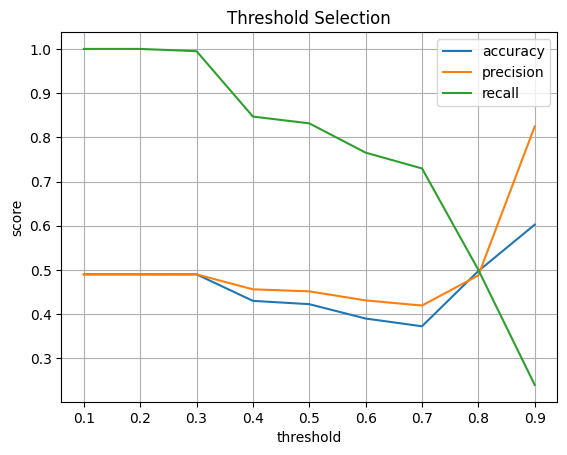

In [15]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pred_proba = clf.predict_proba(x_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

# Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? <br><br>

<table><tr><td>
<img align='center' src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' style='width: 350px;'>
</td><td>
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_002.png' style='width: 400px;'></td></tr></table>
<br>


<span style="color:red">Task: Implement a confussion matrix method from scratch using python list and numpy</span>

In [16]:
def calc_confusion_matrix(true_labels, pred_labels):
    """Compute confusion matrix to evaluate the accuracy of a classification
    
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    pred_labels : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    total_values = np.union1d(np.unique(true_labels), np.unique(pred_labels))

    output = np.zeros((len(total_values), len(total_values)))

    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = np.sum((true_labels==i)&(pred_labels==j))
    
    return output

In [17]:
## computing confusion matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
print("Confusion Matrix for Test 1")
print(calc_confusion_matrix(y_true, y_pred))

covid_test_cm = calc_confusion_matrix(y_test, clf.predict(x_test))
print('Confusion Matrix for Covid-19:\n', covid_test_cm, '\n')

Confusion Matrix for Test 1
[[2. 0. 0.]
 [0. 0. 1.]
 [1. 0. 2.]]
Confusion Matrix for Covid-19:
 [[  6. 198.]
 [ 33. 163.]] 



## <center>Self-Practice  Task</center>

* Using `covid19_self_practice` table dataset given to you.
    1. Split the data to train and test set (80% training). 
    1. Fill missing values
    1. Encode categorical features
    1. Create new features from the existing features
    1. Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.
    1. Select the optimal prediction threshold
    1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them. 

In [18]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn: 
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_self_practice'), con=conn, parse_dates=['test_date']) 
    
covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age,medical_id
0,2021-01-03,0,0,0,0,0,Negative,Yes,male,Other,87,MX0x0
1,2020-10-08,0,0,0,0,0,Negative,No,male,Other,24,MX0x1
2,2021-02-07,0,0,0,0,0,Positive,No,female,Contact with confirmed,57,MX0x2
3,2020-10-12,0,0,0,0,0,Negative,Yes,female,Other,63,MX0x3
4,2020-10-29,0,0,0,0,0,Negative,No,female,Other,39,MX0x4


In [19]:
profile_report = ydata_profiling.profile_report.ProfileReport(covid19_df)

profile_report.to_file("covidius.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# useless for covid predictions
covid19_df.drop(['test_date', 'medical_id'], axis=1, inplace=True)

In [21]:
y = covid19_df['corona_result']
covid19_df.drop(['corona_result'], axis=1, inplace=True)

1. Train-test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(covid19_df, y, train_size=0.8)

In [23]:
x_train.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,age
161,0,0,0,0,0,No,male,Other,42
2978,0,0,0,0,0,No,female,Other,44
5613,0,0,0,0,0,No,male,Other,24
5808,0,0,0,0,0,No,male,Other,22
520,0,0,0,0,0,No,male,Other,47


2. Data imputation

We have two features with missing values in our dataset: gender and test_indication. Over 90% of the test_inidication column belong to class 'Other'. Considering 'Other' could also mean any unknown test_indication, it makes sense to impute missing values using the mode of the feature.

Imputing into gender is more difficult. It contains 5581 instances of class 'female' and 4953 instances of class 'male', so just going with the mode of the class seems unreasonable and not justified. Therefore we will go for kNN method of imputation - data will be encoded, centered and rescaled. Then we will consider genders weighted by distances of n closest neighbours to the row we're trying to determine the gender of, choosing the gender with the shorter distance.

In [24]:
x_train["test_indication"].isna().sum()

382

In [25]:
test_ind_mode = x_train["test_indication"].mode()
x_train.test_indication.fillna(test_ind_mode[0], inplace=True)
x_test.test_indication.fillna(test_ind_mode[0], inplace=True)

In [26]:
print(f"NaNs in train set: {x_train.test_indication.isna().sum()}, NaNs in test set: {x_test.test_indication.isna().sum()}")

NaNs in train set: 0, NaNs in test set: 0


Since we will now be applying KNeighborsClassifier to our dataset to predict gender, we will have to deal with categorical data first.

In [27]:
x_train.dtypes

cough                   int64
fever                   int64
sore_throat             int64
shortness_of_breath     int64
head_ache               int64
age_60_and_above       object
gender                 object
test_indication        object
age                     int64
dtype: object

In [28]:
x_train.age_60_and_above.unique()

array(['No', 'Yes'], dtype=object)

In [29]:
x_train.test_indication.unique()

array(['Other', 'Contact with confirmed', 'Abroad'], dtype=object)

In [30]:
one_h_encoder = OneHotEncoder(cols = ["test_indication"])
x_train = one_h_encoder.fit_transform(x_train)
x_test = one_h_encoder.fit_transform(x_test)

In [31]:
assert len(x_train.columns) == len(x_test.columns), "Check for one-hot encoding not missing any values in test dataset."

In [32]:
x_train.age_60_and_above = x_train.age_60_and_above.map({'No': 0, 'Yes': 1})
x_test.age_60_and_above = x_test.age_60_and_above.map({'No': 0, 'Yes': 1})

In [33]:
x_train_empty_gender = x_train[x_train.gender.isna()]
x_train_has_gender = x_train.drop(x_train_empty_gender.index)
has_gender_target = x_train_has_gender.gender
x_train_has_gender.drop("gender", axis=1, inplace=True)

In [34]:
# before applying distance-weighted KNN it is reasonable to center and scale the age feature 
# all other features are binary, so it would dominate kNN otherwise
x_train_has_gender_train, x_train_has_gender_test, has_gender_target_train, has_gender_target_test = \
    train_test_split(x_train_has_gender, has_gender_target, train_size=0.8)
age_mean_1 = x_train_has_gender_train.age.mean()
age_mean_2 = x_train_has_gender_test.age.mean()
age_std_1= x_train_has_gender_train.age.std()
age_std_2= x_train_has_gender_test.age.std()
x_train_has_gender_train.age = (x_train_has_gender_train.age - age_mean_1) / age_std_1
x_train_has_gender_test.age = (x_train_has_gender_test.age - age_mean_2) / age_std_2
x_train_has_gender_train.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,test_indication_1,test_indication_2,test_indication_3,age
7782,0,0,0,0,0,1,1,0,0,1.711182
3785,0,0,0,0,0,1,1,0,0,1.229480
8489,0,0,0,0,0,0,1,0,0,0.928416
828,0,0,0,0,0,1,1,0,0,1.169267
10810,1,0,0,0,1,0,1,0,0,-1.179030


Now we'll try and search for an optimal K.

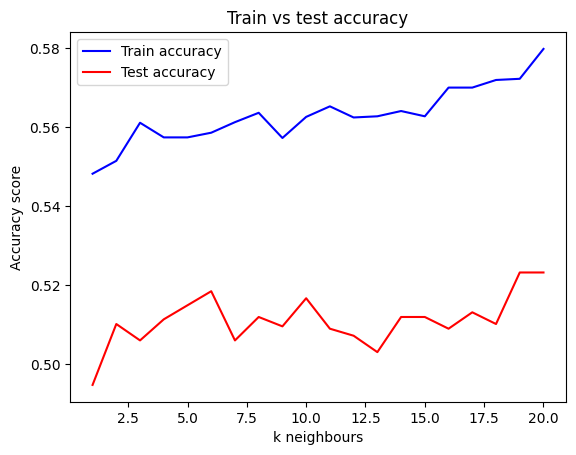

In [35]:
from sklearn.neighbors import KNeighborsClassifier

krange = list(range(1, 21))
train_acc = []
test_acc = []

for k in krange:
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2)
    knn_classifier.fit(x_train_has_gender_train, has_gender_target_train)
    preds_1 = knn_classifier.predict(x_train_has_gender_train)
    train_acc.append(metrics.accuracy_score(has_gender_target_train, preds_1))
    preds_2 = knn_classifier.predict(x_train_has_gender_test)
    test_acc.append(metrics.accuracy_score(has_gender_target_test, preds_2))

plt.plot(krange, train_acc, 'b-', label='Train accuracy')
plt.plot(krange, test_acc, 'r-', label='Test accuracy')
plt.title('Train vs test accuracy')
plt.xlabel('k neighbours')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

It appears that KNN is incapable of detecting a specific pattern between male and female data, as all the accuracies only slightly deviate from the random selection accuracy of 50%. At this point it makes sense to accept that any difference in gender might be impossible to detect when basing off of the same medical symptoms and age, as to my knowledge COVID-19 does not affect men and women with disproportional effects on the surface level. So, we'll simply fill the missing gender values with the column mode, and assume that they are all male.

In [36]:
gender_mode_train = x_train.gender.mode()[0]
gender_mode_test = x_test.gender.mode()[0]

x_train.gender.fillna(gender_mode_train, inplace=True)
x_test.gender.fillna(gender_mode_test, inplace=True)
x_train.gender = x_train.gender.map({"male": 0, "female": 1})
x_test.gender = x_test.gender.map({"male": 0, "female": 1})

x_train.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication_1,test_indication_2,test_indication_3,age
161,0,0,0,0,0,0,0,1,0,0,42
2978,0,0,0,0,0,0,1,1,0,0,44
5613,0,0,0,0,0,0,0,1,0,0,24
5808,0,0,0,0,0,0,0,1,0,0,22
520,0,0,0,0,0,0,0,1,0,0,47


In [37]:
x_train.isna().sum()

cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
age_60_and_above       0
gender                 0
test_indication_1      0
test_indication_2      0
test_indication_3      0
age                    0
dtype: int64

In [38]:
x_test.isna().sum()

cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
age_60_and_above       0
gender                 0
test_indication_1      0
test_indication_2      0
test_indication_3      0
age                    0
dtype: int64

Thus, imputation is done.

3. Encode categorical features

Categorical features were already encoded for X matrices as preparation for kNN imputation of gender, so we only have to encode the target variables.

In [39]:
y_test = y_test.map({"Negative": 0, "Positive": 1})
y_train = y_train.map({"Negative": 0, "Positive": 1})

4. Create new features from the existing features

There's not much room for feature engineering in this dataset for the task of COVID prediction, but we could bin age into several different columns (child (<=12), teenager (13-18), adult (19-59) and the existing old category (>=60)), as well as sum up all the relevant symptoms, as a person who has them all together is much more likely to be COVID-infected compared to a guy who just coughs a bit too much.

In [43]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(age_12_or_below=lambda x: np.where(x['age'] <= 12, 1, 0))
    df = df.assign(age_higher_12_and_lower_19=lambda x: np.where((x['age'] > 12) & (x['age'] < 19), 1, 0))
    df = df.assign(age_higher_18_and_lower_60=lambda x: np.where((x['age'] > 18) & (x['age'] < 60), 1, 0))
    df = df.assign(symptom_count=lambda x: x[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].sum(axis=1))
    return df

In [52]:
x_train = feature_engineering(x_train)
x_test = feature_engineering(x_test)

In [53]:
x_train.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication_1,test_indication_2,test_indication_3,age,age_12_or_below,age_higher_12_and_lower_19,age_higher_18_and_lower_60,symptom_count
161,0,0,0,0,0,0,0,1,0,0,42,0,0,1,0
2978,0,0,0,0,0,0,1,1,0,0,44,0,0,1,0
5613,0,0,0,0,0,0,0,1,0,0,24,0,0,1,0
5808,0,0,0,0,0,0,0,1,0,0,22,0,0,1,0
520,0,0,0,0,0,0,0,1,0,0,47,0,0,1,0


5. Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.

In [54]:
# before training it, i'd like to center and scale the age, as all other variables in the dataset are binary.

mean_1 = x_train.age.mean()
std_1 = x_train.age.std()
mean_2 = x_test.age.mean()
std_2 = x_test.age.std()

x_train.age = (x_train.age - mean_1) / std_1
x_test.age = (x_test.age - mean_2) / std_2

In [55]:
clf = LogisticRegression(solver='liblinear')
clf.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

6. Select the optimal prediction threshold

In [73]:
prediction_thresholds = np.arange(0.05, 1, 0.05)
prediction_probs = pd.DataFrame(clf.predict_proba(x_test))

# let's compose a comprehensive dataframe that contains metrics that interest us.
# Considering how inbalanced the target variable is, just going after better accuracy is irresponsible.
def threshold_selector(thresholds: np.ndarray, probs: pd.DataFrame, y_true: pd.Series) -> pd.DataFrame:
    accuracies = []
    precisions = []
    recalls = []
    for threshold in thresholds:
        y_pred = probs.applymap(lambda x: 1 if x>threshold else 0)
        test_accuracy = metrics.accuracy_score(y_true, y_pred[1])
        test_precision = metrics.precision_score(y_true, y_pred[1], zero_division=0)
        test_recall = metrics.recall_score(y_true, y_pred[1], zero_division=0)
        accuracies.append(test_accuracy)
        precisions.append(test_precision)
        recalls.append(test_recall)
    
    output = pd.DataFrame({'threshold': thresholds, 'accuracy': accuracies, 'precision': precisions, 'recall': recalls})
    return output

threshold_data = threshold_selector(prediction_thresholds, prediction_probs, y_test)

In [75]:
threshold_data.head(100)

,threshold,accuracy,precision,recall
0,0.05,0.236818,0.092845,0.904255
1,0.10,0.889091,0.388000,0.515957
2,0.15,0.890455,0.386266,0.478723
3,0.20,0.892273,0.384977,0.436170
4,0.25,0.894091,0.389163,0.420213
5,0.30,0.895909,0.385475,0.367021
6,0.35,0.904545,0.408333,0.260638
7,0.40,0.904091,0.401709,0.250000
8,0.45,0.905455,0.397959,0.207447
9,0.50,0.905455,0.388889,0.186170


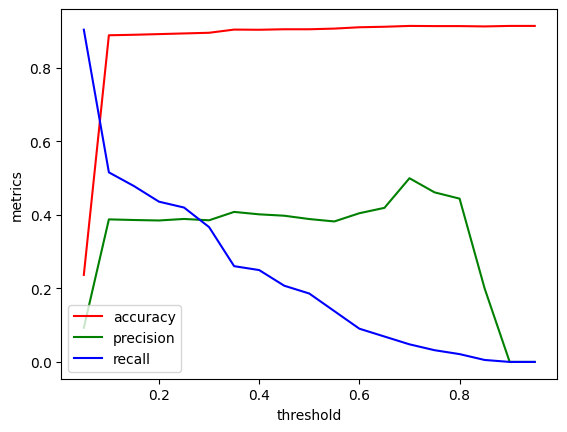

In [76]:
plt.plot(threshold_data['threshold'], threshold_data['accuracy'], 'r-', label='accuracy')
plt.plot(threshold_data['threshold'], threshold_data['precision'], 'g-', label='precision')
plt.plot(threshold_data['threshold'], threshold_data['recall'], 'b-', label='recall')
plt.xlabel('threshold')
plt.ylabel('metrics')
plt.legend()
plt.show()

0.10 appears to be the best threshold, as it balances good accuracy with a high precision score and the highest recall.